# Answering research question 1

In [1]:
import pandas as pd
from collections import Counter

## Loading data

In [2]:
data_pan15_train = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\raw_data\PAN_15_training.csv')
data_pan15_test = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\raw_data\PAN_15_test.csv')

In [3]:
combined_pan15_train = data_pan15_train.groupby('author').agg({
    'text': ' '.join,
    'gender': 'first',
    'age': 'first'
}).reset_index()
combined_pan15_test = data_pan15_test.groupby('author').agg({
    'text': ' '.join,
    'gender': 'first',
    'age': 'first'
}).reset_index()

In [4]:
df_gpt = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt1.csv')
df_gemini = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini1.csv')
df_llama = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama1.csv')

### RQ2

In [124]:
df_gpt2_male = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt2_male.csv')
df_gpt2_female = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt2_female.csv')
df_gpt2_18_24 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt2_18_24.csv')
df_gpt2_25_34 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt2_25_34.csv')
df_gpt2_35_49 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt2_35_49.csv')
df_gpt2_50 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt2_50.csv')

In [136]:
df_gemini2_male = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini2_male.csv')
df_gemini2_female = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini2_female.csv')
df_gemini2_18_24 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini2_18_24.csv')
df_gemini2_25_34 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini2_25_34.csv')
df_gemini2_35_49 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini2_35_49.csv')
df_gemini2_50 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini2_50.csv')

In [137]:
df_llama2_male = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama2_male.csv')
df_llama2_female = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama2_female.csv')
df_llama2_18_24 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama2_18_24.csv')
df_llama2_25_34 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama2_25_34.csv')
df_llama2_35_49 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama2_35_49.csv')
df_llama2_50 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama2_50.csv')

### RQ3

In [138]:
df_gpt3_male = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt3_male.csv')
df_gpt3_female = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt3_female.csv')
df_gpt3_18_24 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt3_18_24.csv')
df_gpt3_25_34 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt3_25_34.csv')
df_gpt3_35_49 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt3_35_49.csv')
df_gpt3_50 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gpt3_50.csv')

In [139]:
df_gemini3_male = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini3_male.csv')
df_gemini3_female = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini3_female.csv')
df_gemini3_18_24 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini3_18_24.csv')
df_gemini3_25_34 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini3_25_34.csv')
df_gemini3_35_49 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini3_35_49.csv')
df_gemini3_50 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\gemini3_50.csv')

In [140]:
df_llama3_male = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama3_male.csv')
df_llama3_female = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama3_female.csv')
df_llama3_18_24 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama3_18_24.csv')
df_llama3_25_34 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama3_25_34.csv')
df_llama3_35_49 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama3_35_49.csv')
df_llama3_50 = pd.read_csv(r'C:\Users\Sten\Documents\EUR BIM\thesis\data\data\llama3_50.csv')

## Variable creation

In [5]:
import re
from nltk.probability import FreqDist
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import statistics


# Character-based features
def character_count(text):
    return len(text)

def alphabetic_ratio(text):
    alphabetic = sum(c.isalpha() for c in text)
    return alphabetic/len(text)

def uppercase_ratio(text):
    upper = sum(c.isupper() for c in text)
    return upper/len(text)

def digit_ratio(text):
    digit = sum(c.isdigit() for c in text)
    return digit/len(text)

def whitespace_ratio(text):
    whitespace = sum(c.isspace() for c in text)
    return whitespace/len(text)

def tab_ratio(text):
    tabs = text.count('\t')
    return tabs/len(text)

def letter_ratio(text, letter):
    text = text.lower()
    letter_count = text.count(letter)
    return letter_count/len(text)

def specialcharacter_ratio(text, character):
    spec_count = text.count(character)
    return spec_count/len(text)

# Word-based features
def number_words(text):
    words = re.findall(r'\b\w+\b', text)
    return len(words)

def word_length(text):
    words = re.findall(r'\b\w+\b', text)
    num_words = len(words)
    if num_words == 0:
        return 0

    total_length = sum(len(word) for word in words)
    return total_length/num_words

def vocabulary_richness(text):
    words = re.findall(r'\b\w+\b', text)
    num_words = len(words)
    if num_words == 0:
        return 0
    
    num_uniq_words = len(set(words))
    return num_uniq_words/num_words

def long_words(text):
    words = re.findall(r'\b\w+\b', text)
    long_words_list = [word for word in words if len(word) > 6]
    return len(long_words_list)/len(words)

def short_words(text):
    words = re.findall(r'\b\w+\b', text)
    short_words_list = [word for word in words if 1 <= len(word) <= 3]
    return len(short_words_list)/len(words)

def legomena(text):
    words = re.findall(r'\b\w+\b', text.lower())
    freq = FreqDist(words)
    legomena = [word for word in freq if freq[word] == 1]
    return len(legomena)/len(words)

def dislegomena(text):
    words = re.findall(r'\b\w+\b', text.lower())
    freq = FreqDist(words)
    dislegomena = [word for word in freq if freq[word] == 2]
    return len(dislegomena)/len(words)

def yules_k(text):
    words = re.findall(r'\b\w+\b', text.lower())
    freq = FreqDist(words)
    N = len(words)
    Vi = FreqDist(freq.values())
    K = 10**4 * ((-N + sum(i**2 * Vi[i] for i in Vi))/N**2)
    return K

def simpson_d(text):
    words = re.findall(r'\b\w+\b', text.lower())
    freq = FreqDist(words)
    N = len(words)
    if N < 2:
        return 0
    D = sum(fr * (fr - 1) / (N * (N - 1)) for fr in freq.values())
    return D

def sichel_s(text):
    words = re.findall(r'\b\w+\b', text.lower())
    freq = FreqDist(words)
    dislegomena = [word for word in freq if freq[word] == 2]
    S = len(dislegomena)/len(freq.values())
    return S

def honores_r(text):
    words = re.findall(r'\b\w+\b', text.lower())
    if not words:
        return 0
    freq = FreqDist(words)
    N = len(words)
    V = len(freq.values())
    legomena = [word for word in freq if freq[word] == 1]
    unique_count_ratio = len(legomena) / V if V > 0 else 0
    if unique_count_ratio == 1 or N == 0:
        return 0
    R = (100*np.log(N)/(1-(len(legomena)/V)))
    return R

def entropy(text):
    words = re.findall(r'\b\w+\b', text.lower())
    freq = FreqDist(words)
    N = len(words)
    E = -sum((fr / N) * np.log(fr/N) for fr in freq.values())
    return E

# Syntatic features
def punctuations_ratio(text, punctuation):
    punctuation_list = re.findall(punctuation, text)
    return len(punctuation_list)/len(text)

# Structural features
def lines(text):
    return len(text.split('\n'))

def sentences(text):
    return len(sent_tokenize(text))

def paragraphs(text):
    return len([par for par in text.split('\n\n') if par.strip()])

def sentence_paragraph(text):
    pars = [par for par in text.split('\n\n') if par.strip()]
    return statistics.mean([len(sent_tokenize(par)) for par in pars])

def words_paragraph(text):
    pars = [par for par in text.split('\n\n') if par.strip()]
    return statistics.mean([len(re.findall(r'\b\w+\b', par)) for par in pars])

def chars_paragraph(text):
    pars = [par for par in text.split('\n\n') if par.strip()]
    return statistics.mean([len(par) for par in pars])

def words_sentences(text):
    sents = sent_tokenize(text)
    return statistics.mean([len(word_tokenize(sentence)) for sentence in sents])

def uppercase_start(text):
    sents = sent_tokenize(text)
    return (sum(1 for sentence in sents if sentence[0].isupper()) / len(sents))

def extract_features(dataframe, text_column):
    features = pd.DataFrame()

    # Character-based features
    features['total_characters'] = dataframe[text_column].apply(character_count)
    features['ratio_alphabetic'] = dataframe[text_column].apply(alphabetic_ratio)
    features['ratio_uppercase'] = dataframe[text_column].apply(uppercase_ratio)
    features['ratio_digit'] = dataframe[text_column].apply(digit_ratio)
    features['ratio_whitespace'] = dataframe[text_column].apply(whitespace_ratio)
    features['ratio_tabspace'] = dataframe[text_column].apply(tab_ratio)
    letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    for letter in letters:
        features[letter+'_frequency'] = dataframe[text_column].apply(letter_ratio, args=(letter,))
    special_characters = ['~', '@', '#', '$', '%', '^', '&', '*', '-', '_', '=', '+', '>', '<', '[', ']', '{', '}', '/', '\\', '|']
    for character in special_characters:
        features[character+'_frequency'] = dataframe[text_column].apply(specialcharacter_ratio, args=(character,))
    
    # Word-based features
    features['total_words'] = dataframe[text_column].apply(number_words)
    features['word_length'] = dataframe[text_column].apply(word_length)
    features['vocabulary_richness'] = dataframe[text_column].apply(vocabulary_richness)
    features['long_words'] = dataframe[text_column].apply(long_words)
    features['short_words'] = dataframe[text_column].apply(short_words)
    features['hapax_legomena'] = dataframe[text_column].apply(legomena)
    features['hapax_dislegomena'] = dataframe[text_column].apply(dislegomena)
    features['yules_k'] = dataframe[text_column].apply(yules_k)
    features['simpson_d'] = dataframe[text_column].apply(simpson_d)
    features['sichel_s'] = dataframe[text_column].apply(sichel_s)
    #features['honore_r'] = dataframe[text_column].apply(honores_r)
    features['entropy'] =  dataframe[text_column].apply(entropy)
    # Brunet W?
    # word length frequency distribution

    
    # Syntactic features
    punctuations = [r"’", r",", r"\.", r":", r";", r"\?", r"\?{2,}", r"!", r"!{2,}", r"\.{3}"]
    for punctuation in punctuations:
        features[punctuation+"_frequency"] = dataframe[text_column].apply(punctuations_ratio, args=(punctuation,))

    # Structural features
    features['number_lines'] = dataframe[text_column].apply(lines)
    features['number_sentences'] = dataframe[text_column].apply(sentences)
    features['number_paragraphs'] = dataframe[text_column].apply(paragraphs)
    features['sentences_per_paragraph'] = dataframe[text_column].apply(sentence_paragraph)
    features['word_per_paragraph'] = dataframe[text_column].apply(words_paragraph)
    features['character_per_paragraph'] = dataframe[text_column].apply(chars_paragraph)
    features['word_per_sentence'] = dataframe[text_column].apply(words_sentences)
    features['ratio_sentencestart_uppercase'] = dataframe[text_column].apply(uppercase_start)
    #features['gender'] = dataframe['gender']
        
    return features


## Data transformation

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
combined_pan15_train_features = extract_features(combined_pan15_train, 'text')
combined_pan15_test_features = extract_features(combined_pan15_test, 'text')

In [8]:
scaler = StandardScaler()
combined_pan15_train_features_scaled = pd.DataFrame(scaler.fit_transform(combined_pan15_train_features), columns=combined_pan15_train_features.columns)
combined_pan15_test_features_scaled = pd.DataFrame(scaler.transform(combined_pan15_test_features), columns=combined_pan15_test_features.columns)

In [9]:
X_train = combined_pan15_train_features_scaled
X_test = combined_pan15_test_features_scaled

In [210]:
y_train = combined_pan15_train['gender']
y_test = combined_pan15_test['gender']

## Training model

In [11]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

In [12]:
model = LinearSVC(max_iter=10000, C= 0.01, class_weight= None, loss= 'squared_hinge', tol= 0.0001)
model.fit(X_train, y_train)

LinearSVC(C=0.01, max_iter=10000)

In [13]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.7535211267605634

## Training improved model

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [15]:
char_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(3, 5), sublinear_tf=True, min_df=2)
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2), sublinear_tf=True, min_df=2)

combined_features = FeatureUnion([
    ('char', char_vectorizer),
    ('word', word_vectorizer)
])

In [16]:
tfidf_features_train = combined_features.fit_transform(combined_pan15_train['text'])
tfidf_features_test =  combined_features.transform(combined_pan15_test['text'])

In [17]:
X_train = hstack([tfidf_features_train, csr_matrix(combined_pan15_train_features_scaled)])
X_test = hstack([tfidf_features_test, csr_matrix(combined_pan15_test_features_scaled)])

In [18]:
label_encoder = LabelEncoder()

In [19]:
def custom_label_encoder(labels, mapping):
    return np.array([mapping[label] for label in labels])

label_mapping = {'F': 1, 'M': 0}
y_train = custom_label_encoder(y_train, label_mapping)
y_test = custom_label_encoder(y_test, label_mapping)

In [211]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [212]:
print("Classes:", label_encoder.classes_)
print("Encoded values:", label_encoder.transform(label_encoder.classes_))

Classes: ['F' 'M']
Encoded values: [0 1]


In [213]:
model = LinearSVC(max_iter=10000, C= 0.01, class_weight= None, loss= 'squared_hinge', tol= 0.0001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))

Accuracy: 0.754
Precision: 0.765
Recall: 0.732


In [23]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Print evaluation metrics
print("Logistic Regression:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 3))
print("Precision:", round(precision_score(y_test, y_pred_lr), 3))
print("Recall:", round(recall_score(y_test, y_pred_lr), 3))

Logistic Regression:
Accuracy: 0.754
Precision: 0.725
Recall: 0.817


In [46]:
model_rf = RandomForestClassifier(random_state=1700)
model_rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = model_rf.predict(X_test)

# Print evaluation metrics
print("Random Forest:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 3))
print("Precision:", round(precision_score(y_test, y_pred_rf), 3))
print("Recall:", round(recall_score(y_test, y_pred_rf), 3))

Random Forest:
Accuracy: 0.711
Precision: 0.697
Recall: 0.746


In [47]:
y_score_svm = model.decision_function(X_test)
y_score_lr = model_lr.predict_proba(X_test)[:, 1]
y_score_rf = model_rf.predict_proba(X_test)[:, 1]

In [48]:
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_logistic, tpr_logistic, _ = roc_curve(y_test, y_score_lr)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

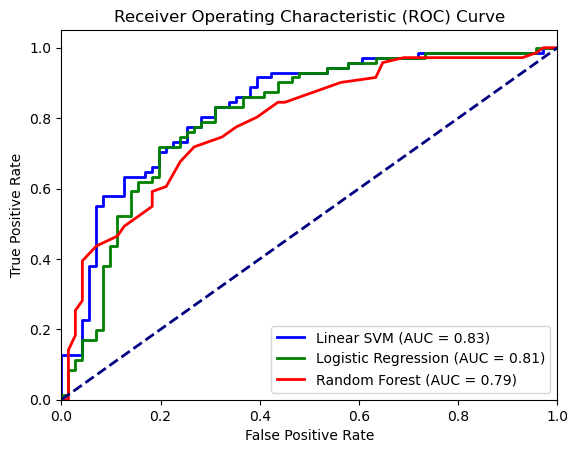

In [49]:
plt.figure()

plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='Linear SVM (AUC = %0.2f)' % roc_auc_svm)
plt.plot(fpr_logistic, tpr_logistic, color='green', lw=2, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logistic)
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc_rf)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

#plt.savefig(r'C:\Users\Sten\Documents\EUR BIM\thesis\graphs/roc_curve_gender1.png')

plt.show()

### Predict age

In [50]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

In [51]:
label_encoder_age = LabelEncoder()

In [93]:
y_train_age = combined_pan15_train['age']
y_test_age = combined_pan15_test['age']

In [53]:
""""
y_train_age = label_encoder_age.fit_transform(y_train_age)
y_test_age = label_encoder_age.transform(y_test_age)
classes = label_encoder_age.classes_
n_classes = len(classes)
"""

In [252]:
"""
classes = np.unique(y_train_age)
y_train_age = label_binarize(y_train_age, classes=classes)
y_test_age = label_binarize(y_test_age, classes=classes)
n_classes = y_train_age.shape[1]
y_train_age_single = np.argmax(y_train_age, axis=1)
"""

In [94]:
model_age = LinearSVC(max_iter=10000, C= 0.01, class_weight= None, loss= 'squared_hinge', tol= 0.0001)
model_age.fit(X_train, y_train_age)
y_pred_age = model_age.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test_age, y_pred_age), 3))
print("Precision:", round(precision_score(y_test_age, y_pred_age, average='weighted'), 3))
print("Recall:", round(recall_score(y_test_age, y_pred_age, average='weighted'), 3))

Accuracy: 0.697
Precision: 0.695
Recall: 0.697


In [96]:
model_lr_age = LogisticRegression()
model_lr_age.fit(X_train, y_train_age)

# Make predictions
y_pred_lr_age = model_lr_age.predict(X_test)

# Print evaluation metrics
print("Logistic Regression:")
print("Accuracy:", round(accuracy_score(y_test_age, y_pred_lr_age), 3))
print("Precision:", round(precision_score(y_test_age, y_pred_lr_age, average='weighted'), 3))
print("Recall:", round(recall_score(y_test_age, y_pred_lr_age, average='weighted'), 3))

Logistic Regression:
Accuracy: 0.655
Precision: 0.677
Recall: 0.655


In [95]:
model_rf_age = RandomForestClassifier(random_state=7390)
model_rf_age.fit(X_train, y_train_age)

# Make predictions
y_pred_rf_age = model_rf_age.predict(X_test)

# Print evaluation metrics
print("Random Forest:")
print("Accuracy:", round(accuracy_score(y_test_age, y_pred_rf_age), 3))
print("Precision:", round(precision_score(y_test_age, y_pred_rf_age, average='weighted'), 3))
print("Recall:", round(recall_score(y_test_age, y_pred_rf_age, average='weighted'), 3))

Random Forest:
Accuracy: 0.683
Precision: 0.686
Recall: 0.683


c:\Users\Sten\AppData\Local\R-MINI~1\envs\python39\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [267]:
y_score_svm_age = model_age.decision_function(X_test)
y_score_lr_age = model_lr_age.predict_proba(X_test)
y_score_rf_age = model_rf_age.predict_proba(X_test)

In [269]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Binary representation for the current class
    y_test_binary = np.where(y_test_age == i, 1, 0)
    
    fpr[f'svm_{i}'], tpr[f'svm_{i}'], _ = roc_curve(y_test_binary, y_score_svm_age[:, i] if y_score_svm_age.ndim > 1 else y_score_svm_age)
    roc_auc[f'svm_{i}'] = auc(fpr[f'svm_{i}'], tpr[f'svm_{i}'])

    fpr[f'logistic_{i}'], tpr[f'logistic_{i}'], _ = roc_curve(y_test_binary, y_score_lr_age[:, i])
    roc_auc[f'logistic_{i}'] = auc(fpr[f'logistic_{i}'], tpr[f'logistic_{i}'])

    fpr[f'rf_{i}'], tpr[f'rf_{i}'], _ = roc_curve(y_test_binary, y_score_rf_age[:, i])
    roc_auc[f'rf_{i}'] = auc(fpr[f'rf_{i}'], tpr[f'rf_{i}'])

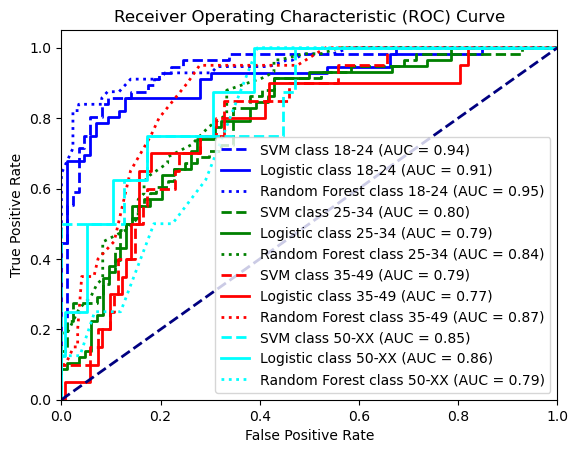

In [272]:
colors = cycle(['blue', 'green', 'red', 'cyan'])

plt.figure()

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[f'svm_{i}'], tpr[f'svm_{i}'], color=color, lw=2, linestyle='--', label=f'SVM class {classes[i]} (AUC = {roc_auc[f"svm_{i}"]:.2f})')
    plt.plot(fpr[f'logistic_{i}'], tpr[f'logistic_{i}'], color=color, lw=2, linestyle='-', label=f'Logistic class {classes[i]} (AUC = {roc_auc[f"logistic_{i}"]:.2f})')
    plt.plot(fpr[f'rf_{i}'], tpr[f'rf_{i}'], color=color, lw=2, linestyle=':', label=f'Random Forest class {classes[i]} (AUC = {roc_auc[f"rf_{i}"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.show()

In [54]:
Counter(y_pred)

Counter({'25-34': 66, '18-24': 52, '35-49': 15, '50-XX': 9})

## Predicting LLM data RQ1

In [65]:
gpt_features = extract_features(df_gpt, 'text')
gemini_features = extract_features(df_gemini, 'text')
llama_features = extract_features(df_llama, 'text')

In [66]:
gpt_features_scaled = pd.DataFrame(scaler.transform(gpt_features), columns=gpt_features.columns)
gemini_features_scaled = pd.DataFrame(scaler.transform(gemini_features), columns=gemini_features.columns)
llama_features_scaled = pd.DataFrame(scaler.transform(llama_features), columns=llama_features.columns)

In [67]:
gpt_features_tfidf = combined_features.transform(df_gpt['text'])
gpt_features_combined = hstack([gpt_features_tfidf, csr_matrix(gpt_features_scaled)])

In [68]:
gemini_features_tfidf = combined_features.transform(df_gemini['text'])
gemini_features_combined = hstack([gemini_features_tfidf, csr_matrix(gemini_features_scaled)])

In [69]:
llama_features_tfidf = combined_features.transform(df_llama['text'])
llama_features_combined = hstack([llama_features_tfidf, csr_matrix(llama_features_scaled)])

### Gender

In [206]:
gpt_pred = model.predict(gpt_features_combined)
print(Counter(gpt_pred)[1]/len(gpt_pred))
Counter(gpt_pred)

0.564


Counter({0: 109, 1: 141})

In [207]:
gemini_pred = model.predict(gemini_features_combined)
print(Counter(gemini_pred)[1]/len(gemini_pred))
Counter(gemini_pred)

0.043795620437956206


Counter({0: 131, 1: 6})

In [208]:
llama_pred = model.predict(llama_features_combined)
print(Counter(llama_pred)[1]/len(llama_pred))
Counter(llama_pred)

0.31746031746031744


Counter({1: 60, 0: 129})

## Analysis

In [74]:
import numpy as np
from scipy.stats import chi2_contingency, chisquare

In [75]:
contingency_table = pd.DataFrame({
    "GPT" : pd.Series(gpt_pred).value_counts(),
    "Gemini" : pd.Series(gemini_pred).value_counts(),
    "Llama" : pd.Series(llama_pred).value_counts()
})

In [76]:
contingency_table

,GPT,Gemini,Llama
0,109,131,129
1,141,6,60


In [77]:
chi2, p, dof, expected = chi2_contingency(contingency_table.T)

In [78]:
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(pd.DataFrame(expected, index=contingency_table.columns, columns=contingency_table.index))


Chi-Square Test Results:
Chi-Square Statistic: 106.17356605188846
P-Value: 8.804466996342325e-24
Degrees of Freedom: 2
Expected Frequencies:
                 0          1
GPT     160.156250  89.843750
Gemini   87.765625  49.234375
Llama   121.078125  67.921875


In [79]:
expected_frequencies = [len(gpt_pred)/2, len(gpt_pred)/2]
chi2_stat, p_val = chisquare(pd.Series(gpt_pred).value_counts(), expected_frequencies)

print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square statistic: 4.096
P-value: 0.042984795070858665


In [80]:
expected_frequencies = [len(gemini_pred)/2, len(gemini_pred)/2]
chi2_stat, p_val = chisquare(pd.Series(gemini_pred).value_counts(), expected_frequencies)

print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square statistic: 114.05109489051095
P-value: 1.2699362592974781e-26


In [81]:
expected_frequencies = [len(llama_pred)/2, len(llama_pred)/2]
chi2_stat, p_val = chisquare(pd.Series(llama_pred).value_counts(), expected_frequencies)

print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square statistic: 25.19047619047619
P-value: 5.193804760844568e-07


### Age

In [97]:
gpt_pred_age = model_age.predict(gpt_features_combined)
Counter(gpt_pred_age)

Counter({'25-34': 250})

In [98]:
gemini_pred_age = model_age.predict(gemini_features_combined)
Counter(gemini_pred_age)

Counter({'25-34': 115, '35-49': 22})

In [99]:
llama_pred_age = model_age.predict(llama_features_combined)
Counter(llama_pred_age)

Counter({'18-24': 21, '25-34': 147, '35-49': 21})

In [113]:
contingency_table_age = pd.DataFrame({
    "GPT" : pd.Series(gpt_pred_age).value_counts(),
    "Gemini" : pd.Series(gemini_pred_age).value_counts(),
    "Llama" : pd.Series(llama_pred_age).value_counts()
}).fillna(0).astype(int)

In [114]:
chi2, p, dof, expected = chi2_contingency(contingency_table_age)
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(pd.DataFrame(expected))


Chi-Square Test Results:
Chi-Square Statistic: 85.05398064844678
P-Value: 1.4774793140887388e-17
Degrees of Freedom: 4
Expected Frequencies:
            0           1           2
0    9.114583    4.994792    6.890625
1  222.222222  121.777778  168.000000
2   18.663194   10.227431   14.109375


In [115]:
contingency_table_age.loc['50+'] = [0,0,0]

In [116]:
contingency_table_age

,GPT,Gemini,Llama
18-24,0,0,21
25-34,250,115,147
35-49,0,22,21
50+,0,0,0


In [105]:
pd.Series(gpt_pred_age).value_counts()

25-34    250
dtype: int64

In [118]:
expected_frequencies = [len(gpt_pred_age)*0.38690, len(gpt_pred_age)*0.39881, len(gpt_pred_age)*0.14286, len(gpt_pred_age)*0.07143]
chi2_stat, p_val = chisquare(contingency_table_age['GPT'], expected_frequencies)

print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square statistic: 376.86492314636047
P-value: 2.269877829742244e-81


In [121]:
expected_frequencies = [len(gemini_pred_age)*0.38690, len(gemini_pred_age)*0.39881, len(gemini_pred_age)*0.14286, len(gemini_pred_age)*0.07143]
chi2_stat, p_val = chisquare(contingency_table_age['Gemini'], expected_frequencies)

print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square statistic: 129.78165456786598
P-value: 6.0273582001307705e-28


In [123]:
expected_frequencies = [len(llama_pred_age)*0.38690, len(llama_pred_age)*0.39881, len(llama_pred_age)*0.14286, len(llama_pred_age)*0.07143]
chi2_stat, p_val = chisquare(contingency_table_age['Llama'], expected_frequencies)

print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_val}")

Chi-square statistic: 120.05007498200354
P-value: 7.52752452704496e-26


## RQ2 data

### GPT

In [166]:
gpt2_male_features = extract_features(df_gpt2_male, 'text')
gpt2_female_features = extract_features(df_gpt2_female, 'text')
gpt2_18_24_features = extract_features(df_gpt2_18_24, 'text')
gpt2_25_34_features = extract_features(df_gpt2_25_34, 'text')
gpt2_35_49_features = extract_features(df_gpt2_35_49, 'text')
gpt2_50_features = extract_features(df_gpt2_50, 'text')

gpt2_male_features_scaled = pd.DataFrame(scaler.transform(gpt2_male_features), columns=gpt2_male_features.columns)
gpt2_female_features_scaled = pd.DataFrame(scaler.transform(gpt2_female_features), columns=gpt2_female_features.columns)
gpt2_18_24_features_scaled = pd.DataFrame(scaler.transform(gpt2_18_24_features), columns=gpt2_18_24_features.columns)
gpt2_25_34_features_scaled = pd.DataFrame(scaler.transform(gpt2_25_34_features), columns=gpt2_25_34_features.columns)
gpt2_35_49_features_scaled = pd.DataFrame(scaler.transform(gpt2_35_49_features), columns=gpt2_35_49_features.columns)
gpt2_50_features_scaled = pd.DataFrame(scaler.transform(gpt2_50_features), columns=gpt2_50_features.columns)

gpt2_male_features_tfidf = combined_features.transform(df_gpt2_male['text'])
gpt2_female_features_tfidf = combined_features.transform(df_gpt2_female['text'])
gpt2_18_24_features_tfidf = combined_features.transform(df_gpt2_18_24['text'])
gpt2_25_34_features_tfidf = combined_features.transform(df_gpt2_25_34['text'])
gpt2_35_49_features_tfidf = combined_features.transform(df_gpt2_35_49['text'])
gpt2_50_features_tfidf = combined_features.transform(df_gpt2_50['text'])

gpt2_male_features_combined = hstack([gpt2_male_features_tfidf, csr_matrix(gpt2_male_features_scaled)])
gpt2_female_features_combined = hstack([gpt2_female_features_tfidf, csr_matrix(gpt2_female_features_scaled)])
gpt2_18_24_features_combined = hstack([gpt2_18_24_features_tfidf, csr_matrix(gpt2_18_24_features_scaled)])
gpt2_25_34_features_combined = hstack([gpt2_25_34_features_tfidf, csr_matrix(gpt2_25_34_features_scaled)])
gpt2_35_49_features_combined = hstack([gpt2_35_49_features_tfidf, csr_matrix(gpt2_35_49_features_scaled)])
gpt2_50_features_combined = hstack([gpt2_50_features_tfidf, csr_matrix(gpt2_50_features_scaled)])

### Gemini

In [167]:
gemini2_male_features = extract_features(df_gemini2_male, 'text')
gemini2_female_features = extract_features(df_gemini2_female, 'text')
gemini2_18_24_features = extract_features(df_gemini2_18_24, 'text')
gemini2_25_34_features = extract_features(df_gemini2_25_34, 'text')
gemini2_35_49_features = extract_features(df_gemini2_35_49, 'text')
gemini2_50_features = extract_features(df_gemini2_50, 'text')

gemini2_male_features_scaled = pd.DataFrame(scaler.transform(gemini2_male_features), columns=gemini2_male_features.columns)
gemini2_female_features_scaled = pd.DataFrame(scaler.transform(gemini2_female_features), columns=gemini2_female_features.columns)
gemini2_18_24_features_scaled = pd.DataFrame(scaler.transform(gemini2_18_24_features), columns=gemini2_18_24_features.columns)
gemini2_25_34_features_scaled = pd.DataFrame(scaler.transform(gemini2_25_34_features), columns=gemini2_25_34_features.columns)
gemini2_35_49_features_scaled = pd.DataFrame(scaler.transform(gemini2_35_49_features), columns=gemini2_35_49_features.columns)
gemini2_50_features_scaled = pd.DataFrame(scaler.transform(gemini2_50_features), columns=gemini2_50_features.columns)

gemini2_male_features_tfidf = combined_features.transform(df_gemini2_male['text'])
gemini2_female_features_tfidf = combined_features.transform(df_gemini2_female['text'])
gemini2_18_24_features_tfidf = combined_features.transform(df_gemini2_18_24['text'])
gemini2_25_34_features_tfidf = combined_features.transform(df_gemini2_25_34['text'])
gemini2_35_49_features_tfidf = combined_features.transform(df_gemini2_35_49['text'])
gemini2_50_features_tfidf = combined_features.transform(df_gemini2_50['text'])

gemini2_male_features_combined = hstack([gemini2_male_features_tfidf, csr_matrix(gemini2_male_features_scaled)])
gemini2_female_features_combined = hstack([gemini2_female_features_tfidf, csr_matrix(gemini2_female_features_scaled)])
gemini2_18_24_features_combined = hstack([gemini2_18_24_features_tfidf, csr_matrix(gemini2_18_24_features_scaled)])
gemini2_25_34_features_combined = hstack([gemini2_25_34_features_tfidf, csr_matrix(gemini2_25_34_features_scaled)])
gemini2_35_49_features_combined = hstack([gemini2_35_49_features_tfidf, csr_matrix(gemini2_35_49_features_scaled)])
gemini2_50_features_combined = hstack([gemini2_50_features_tfidf, csr_matrix(gemini2_50_features_scaled)])

### Llama

In [168]:
llama2_male_features = extract_features(df_llama2_male, 'text')
llama2_female_features = extract_features(df_llama2_female, 'text')
llama2_18_24_features = extract_features(df_llama2_18_24, 'text')
llama2_25_34_features = extract_features(df_llama2_25_34, 'text')
llama2_35_49_features = extract_features(df_llama2_35_49, 'text')
llama2_50_features = extract_features(df_llama2_50, 'text')

llama2_male_features_scaled = pd.DataFrame(scaler.transform(llama2_male_features), columns=llama2_male_features.columns)
llama2_female_features_scaled = pd.DataFrame(scaler.transform(llama2_female_features), columns=llama2_female_features.columns)
llama2_18_24_features_scaled = pd.DataFrame(scaler.transform(llama2_18_24_features), columns=llama2_18_24_features.columns)
llama2_25_34_features_scaled = pd.DataFrame(scaler.transform(llama2_25_34_features), columns=llama2_25_34_features.columns)
llama2_35_49_features_scaled = pd.DataFrame(scaler.transform(llama2_35_49_features), columns=llama2_35_49_features.columns)
llama2_50_features_scaled = pd.DataFrame(scaler.transform(llama2_50_features), columns=llama2_50_features.columns)

llama2_male_features_tfidf = combined_features.transform(df_llama2_male['text'])
llama2_female_features_tfidf = combined_features.transform(df_llama2_female['text'])
llama2_18_24_features_tfidf = combined_features.transform(df_llama2_18_24['text'])
llama2_25_34_features_tfidf = combined_features.transform(df_llama2_25_34['text'])
llama2_35_49_features_tfidf = combined_features.transform(df_llama2_35_49['text'])
llama2_50_features_tfidf = combined_features.transform(df_llama2_50['text'])

llama2_male_features_combined = hstack([llama2_male_features_tfidf, csr_matrix(llama2_male_features_scaled)])
llama2_female_features_combined = hstack([llama2_female_features_tfidf, csr_matrix(llama2_female_features_scaled)])
llama2_18_24_features_combined = hstack([llama2_18_24_features_tfidf, csr_matrix(llama2_18_24_features_scaled)])
llama2_25_34_features_combined = hstack([llama2_25_34_features_tfidf, csr_matrix(llama2_25_34_features_scaled)])
llama2_35_49_features_combined = hstack([llama2_35_49_features_tfidf, csr_matrix(llama2_35_49_features_scaled)])
llama2_50_features_combined = hstack([llama2_50_features_tfidf, csr_matrix(llama2_50_features_scaled)])

## RQ2 analysis

In [215]:
gpt2_male_pred = model.predict(gpt2_male_features_combined)
gpt2_female_pred = model.predict(gpt2_female_features_combined)
gpt2_18_24_pred = model_age.predict(gpt2_18_24_features_combined)
gpt2_25_34_pred = model_age.predict(gpt2_25_34_features_combined)
gpt2_35_49_pred = model_age.predict(gpt2_35_49_features_combined)
gpt2_50_pred = model_age.predict(gpt2_50_features_combined)


print("0 = female, 1 = male \n")
print("Male-ratio gpt2_male: "+ str(Counter(gpt2_male_pred)[1]/len(gpt2_male_pred)))
print("Distibution gpt2_male: " + str(Counter(gpt2_male_pred)) + "\n")

print("Male-ratio gpt2_female: "+ str(Counter(gpt2_female_pred)[1]/len(gpt2_female_pred)))
print("Distibution gpt2_female: " + str(Counter(gpt2_female_pred)) + "\n")

print("Distibution gpt2_18_24: " + str(Counter(gpt2_18_24_pred)) + "\n")

print("Distibution gpt2_25_34: " + str(Counter(gpt2_25_34_pred)) + "\n")

print("Distibution gpt2_35_49: " + str(Counter(gpt2_35_49_pred)) + "\n")

print("Distibution gpt2_50: " + str(Counter(gpt2_50_pred)) + "\n")

0 = female, 1 = male 

Male-ratio gpt2_male: 1.0
Distibution gpt2_male: Counter({1: 104})

Male-ratio gpt2_female: 1.0
Distibution gpt2_female: Counter({1: 101})

Distibution gpt2_18_24: Counter({'35-49': 60})

Distibution gpt2_25_34: Counter({'25-34': 53})

Distibution gpt2_35_49: Counter({'25-34': 54})

Distibution gpt2_50: Counter({'25-34': 46, '35-49': 11})



In [203]:
gemini2_male_pred = model.predict(gemini2_male_features_combined)
gemini2_female_pred = model.predict(gemini2_female_features_combined)
gemini2_18_24_pred = model_age.predict(gemini2_18_24_features_combined)
gemini2_25_34_pred = model_age.predict(gemini2_25_34_features_combined)
gemini2_35_49_pred = model_age.predict(gemini2_35_49_features_combined)
gemini2_50_pred = model_age.predict(gemini2_50_features_combined)


print("Male-ratio gemini2_male: "+ str(Counter(gemini2_male_pred)[1]/len(gemini2_male_pred)))
print("Distibution gemini2_male: " + str(Counter(gemini2_male_pred)) + "\n")

print("Male-ratio gemini2_female: "+ str(Counter(gemini2_female_pred)[1]/len(gemini2_female_pred)))
print("Distibution gemini2_female: " + str(Counter(gemini2_female_pred)) + "\n")

print("Distibution gemini2_18_24: " + str(Counter(gemini2_18_24_pred)) + "\n")

print("Distibution gemini2_25_34: " + str(Counter(gemini2_25_34_pred)) + "\n")

print("Distibution gemini2_35_49: " + str(Counter(gemini2_35_49_pred)) + "\n")

print("Distibution gemini2_50: " + str(Counter(gemini2_50_pred)) + "\n")

Male-ratio gemini2_male: 0.018867924528301886
Distibution gemini2_male: Counter({0: 52, 1: 1})

Male-ratio gemini2_female: 0.0
Distibution gemini2_female: Counter({0: 51})

Distibution gemini2_18_24: Counter({'25-34': 51})

Distibution gemini2_25_34: Counter({'25-34': 49, '35-49': 6})

Distibution gemini2_35_49: Counter({'35-49': 47, '25-34': 3})

Distibution gemini2_50: Counter({'25-34': 51})



In [204]:
llama2_male_pred = model.predict(llama2_male_features_combined)
llama2_female_pred = model.predict(llama2_female_features_combined)
llama2_18_24_pred = model_age.predict(llama2_18_24_features_combined)
llama2_25_34_pred = model_age.predict(llama2_25_34_features_combined)
llama2_35_49_pred = model_age.predict(llama2_35_49_features_combined)
llama2_50_pred = model_age.predict(llama2_50_features_combined)


print("Male-ratio llama2_male: "+ str(Counter(llama2_male_pred)[1]/len(llama2_male_pred)))
print("Distibution llama2_male: " + str(Counter(llama2_male_pred)) + "\n")

print("Male-ratio llama2_female: "+ str(Counter(llama2_female_pred)[1]/len(llama2_female_pred)))
print("Distibution llama2_female: " + str(Counter(llama2_female_pred)) + "\n")

print("Distibution llama2_18_24: " + str(Counter(llama2_18_24_pred)) + "\n")

print("Distibution llama2_25_34: " + str(Counter(llama2_25_34_pred)) + "\n")

print("Distibution llama2_35_49: " + str(Counter(llama2_35_49_pred)) + "\n")

print("Distibution llama2_50: " + str(Counter(llama2_50_pred)) + "\n")

Male-ratio llama2_male: 0.24528301886792453
Distibution llama2_male: Counter({0: 40, 1: 13})

Male-ratio llama2_female: 0.24561403508771928
Distibution llama2_female: Counter({0: 43, 1: 14})

Distibution llama2_18_24: Counter({'25-34': 47, '35-49': 4, '18-24': 4})

Distibution llama2_25_34: Counter({'25-34': 48, '18-24': 8, '35-49': 5})

Distibution llama2_35_49: Counter({'25-34': 42, '18-24': 13, '35-49': 4})

Distibution llama2_50: Counter({'25-34': 54, '18-24': 11, '35-49': 5})



## RQ3 data

### GPT

In [169]:
gpt3_male_features = extract_features(df_gpt3_male, 'text')
gpt3_female_features = extract_features(df_gpt3_female, 'text')
gpt3_18_24_features = extract_features(df_gpt3_18_24, 'text')
gpt3_25_34_features = extract_features(df_gpt3_25_34, 'text')
gpt3_35_49_features = extract_features(df_gpt3_35_49, 'text')
gpt3_50_features = extract_features(df_gpt3_50, 'text')

gpt3_male_features_scaled = pd.DataFrame(scaler.transform(gpt3_male_features), columns=gpt3_male_features.columns)
gpt3_female_features_scaled = pd.DataFrame(scaler.transform(gpt3_female_features), columns=gpt3_female_features.columns)
gpt3_18_24_features_scaled = pd.DataFrame(scaler.transform(gpt3_18_24_features), columns=gpt3_18_24_features.columns)
gpt3_25_34_features_scaled = pd.DataFrame(scaler.transform(gpt3_25_34_features), columns=gpt3_25_34_features.columns)
gpt3_35_49_features_scaled = pd.DataFrame(scaler.transform(gpt3_35_49_features), columns=gpt3_35_49_features.columns)
gpt3_50_features_scaled = pd.DataFrame(scaler.transform(gpt3_50_features), columns=gpt3_50_features.columns)

gpt3_male_features_tfidf = combined_features.transform(df_gpt3_male['text'])
gpt3_female_features_tfidf = combined_features.transform(df_gpt3_female['text'])
gpt3_18_24_features_tfidf = combined_features.transform(df_gpt3_18_24['text'])
gpt3_25_34_features_tfidf = combined_features.transform(df_gpt3_25_34['text'])
gpt3_35_49_features_tfidf = combined_features.transform(df_gpt3_35_49['text'])
gpt3_50_features_tfidf = combined_features.transform(df_gpt3_50['text'])

gpt3_male_features_combined = hstack([gpt3_male_features_tfidf, csr_matrix(gpt3_male_features_scaled)])
gpt3_female_features_combined = hstack([gpt3_female_features_tfidf, csr_matrix(gpt3_female_features_scaled)])
gpt3_18_24_features_combined = hstack([gpt3_18_24_features_tfidf, csr_matrix(gpt3_18_24_features_scaled)])
gpt3_25_34_features_combined = hstack([gpt3_25_34_features_tfidf, csr_matrix(gpt3_25_34_features_scaled)])
gpt3_35_49_features_combined = hstack([gpt3_35_49_features_tfidf, csr_matrix(gpt3_35_49_features_scaled)])
gpt3_50_features_combined = hstack([gpt3_50_features_tfidf, csr_matrix(gpt3_50_features_scaled)])

### Gemini

In [170]:
gemini3_male_features = extract_features(df_gemini3_male, 'text')
gemini3_female_features = extract_features(df_gemini3_female, 'text')
gemini3_18_24_features = extract_features(df_gemini3_18_24, 'text')
gemini3_25_34_features = extract_features(df_gemini3_25_34, 'text')
gemini3_35_49_features = extract_features(df_gemini3_35_49, 'text')
gemini3_50_features = extract_features(df_gemini3_50, 'text')

gemini3_male_features_scaled = pd.DataFrame(scaler.transform(gemini3_male_features), columns=gemini3_male_features.columns)
gemini3_female_features_scaled = pd.DataFrame(scaler.transform(gemini3_female_features), columns=gemini3_female_features.columns)
gemini3_18_24_features_scaled = pd.DataFrame(scaler.transform(gemini3_18_24_features), columns=gemini3_18_24_features.columns)
gemini3_25_34_features_scaled = pd.DataFrame(scaler.transform(gemini3_25_34_features), columns=gemini3_25_34_features.columns)
gemini3_35_49_features_scaled = pd.DataFrame(scaler.transform(gemini3_35_49_features), columns=gemini3_35_49_features.columns)
gemini3_50_features_scaled = pd.DataFrame(scaler.transform(gemini3_50_features), columns=gemini3_50_features.columns)

gemini3_male_features_tfidf = combined_features.transform(df_gemini3_male['text'])
gemini3_female_features_tfidf = combined_features.transform(df_gemini3_female['text'])
gemini3_18_24_features_tfidf = combined_features.transform(df_gemini3_18_24['text'])
gemini3_25_34_features_tfidf = combined_features.transform(df_gemini3_25_34['text'])
gemini3_35_49_features_tfidf = combined_features.transform(df_gemini3_35_49['text'])
gemini3_50_features_tfidf = combined_features.transform(df_gemini3_50['text'])

gemini3_male_features_combined = hstack([gemini3_male_features_tfidf, csr_matrix(gemini3_male_features_scaled)])
gemini3_female_features_combined = hstack([gemini3_female_features_tfidf, csr_matrix(gemini3_female_features_scaled)])
gemini3_18_24_features_combined = hstack([gemini3_18_24_features_tfidf, csr_matrix(gemini3_18_24_features_scaled)])
gemini3_25_34_features_combined = hstack([gemini3_25_34_features_tfidf, csr_matrix(gemini3_25_34_features_scaled)])
gemini3_35_49_features_combined = hstack([gemini3_35_49_features_tfidf, csr_matrix(gemini3_35_49_features_scaled)])
gemini3_50_features_combined = hstack([gemini3_50_features_tfidf, csr_matrix(gemini3_50_features_scaled)])

### Llama

In [171]:
llama3_male_features = extract_features(df_llama3_male, 'text')
llama3_female_features = extract_features(df_llama3_female, 'text')
llama3_18_24_features = extract_features(df_llama3_18_24, 'text')
llama3_25_34_features = extract_features(df_llama3_25_34, 'text')
llama3_35_49_features = extract_features(df_llama3_35_49, 'text')
llama3_50_features = extract_features(df_llama3_50, 'text')

llama3_male_features_scaled = pd.DataFrame(scaler.transform(llama3_male_features), columns=llama3_male_features.columns)
llama3_female_features_scaled = pd.DataFrame(scaler.transform(llama3_female_features), columns=llama3_female_features.columns)
llama3_18_24_features_scaled = pd.DataFrame(scaler.transform(llama3_18_24_features), columns=llama3_18_24_features.columns)
llama3_25_34_features_scaled = pd.DataFrame(scaler.transform(llama3_25_34_features), columns=llama3_25_34_features.columns)
llama3_35_49_features_scaled = pd.DataFrame(scaler.transform(llama3_35_49_features), columns=llama3_35_49_features.columns)
llama3_50_features_scaled = pd.DataFrame(scaler.transform(llama3_50_features), columns=llama3_50_features.columns)

llama3_male_features_tfidf = combined_features.transform(df_llama3_male['text'])
llama3_female_features_tfidf = combined_features.transform(df_llama3_female['text'])
llama3_18_24_features_tfidf = combined_features.transform(df_llama3_18_24['text'])
llama3_25_34_features_tfidf = combined_features.transform(df_llama3_25_34['text'])
llama3_35_49_features_tfidf = combined_features.transform(df_llama3_35_49['text'])
llama3_50_features_tfidf = combined_features.transform(df_llama3_50['text'])

llama3_male_features_combined = hstack([llama3_male_features_tfidf, csr_matrix(llama3_male_features_scaled)])
llama3_female_features_combined = hstack([llama3_female_features_tfidf, csr_matrix(llama3_female_features_scaled)])
llama3_18_24_features_combined = hstack([llama3_18_24_features_tfidf, csr_matrix(llama3_18_24_features_scaled)])
llama3_25_34_features_combined = hstack([llama3_25_34_features_tfidf, csr_matrix(llama3_25_34_features_scaled)])
llama3_35_49_features_combined = hstack([llama3_35_49_features_tfidf, csr_matrix(llama3_35_49_features_scaled)])
llama3_50_features_combined = hstack([llama3_50_features_tfidf, csr_matrix(llama3_50_features_scaled)])

## RQ3 analysis

In [216]:
gpt3_male_pred = model.predict(gpt3_male_features_combined)
gpt3_female_pred = model.predict(gpt3_female_features_combined)
gpt3_18_24_pred = model_age.predict(gpt3_18_24_features_combined)
gpt3_25_34_pred = model_age.predict(gpt3_25_34_features_combined)
gpt3_35_49_pred = model_age.predict(gpt3_35_49_features_combined)
gpt3_50_pred = model_age.predict(gpt3_50_features_combined)


print("0 = female, 1 = male \n")
print("Male-ratio gpt3_male: "+ str(Counter(gpt3_male_pred)[1]/len(gpt3_male_pred)))
print("Distibution gpt3_male: " + str(Counter(gpt3_male_pred)) + "\n")

print("Male-ratio gpt3_female: "+ str(Counter(gpt3_female_pred)[1]/len(gpt3_female_pred)))
print("Distibution gpt3_female: " + str(Counter(gpt3_female_pred)) + "\n")

print("Distibution gpt3_18_24: " + str(Counter(gpt3_18_24_pred)) + "\n")

print("Distibution gpt3_25_34: " + str(Counter(gpt3_25_34_pred)) + "\n")

print("Distibution gpt3_35_49: " + str(Counter(gpt3_35_49_pred)) + "\n")

print("Distibution gpt3_50: " + str(Counter(gpt3_50_pred)) + "\n")

0 = female, 1 = male 

Male-ratio gpt3_male: 0.9433962264150944
Distibution gpt3_male: Counter({1: 50, 0: 3})

Male-ratio gpt3_female: 0.7166666666666667
Distibution gpt3_female: Counter({1: 43, 0: 17})

Distibution gpt3_18_24: Counter({'35-49': 45, '25-34': 8})

Distibution gpt3_25_34: Counter({'25-34': 40, '35-49': 17, '18-24': 1})

Distibution gpt3_35_49: Counter({'35-49': 45, '25-34': 8})

Distibution gpt3_50: Counter({'35-49': 38, '18-24': 13, '25-34': 2, '50-XX': 2})



In [217]:
gemini3_male_pred = model.predict(gemini3_male_features_combined)
gemini3_female_pred = model.predict(gemini3_female_features_combined)
gemini3_18_24_pred = model_age.predict(gemini3_18_24_features_combined)
gemini3_25_34_pred = model_age.predict(gemini3_25_34_features_combined)
gemini3_35_49_pred = model_age.predict(gemini3_35_49_features_combined)
gemini3_50_pred = model_age.predict(gemini3_50_features_combined)


print("Male-ratio gemini3_male: "+ str(Counter(gemini3_male_pred)[1]/len(gemini3_male_pred)))
print("Distibution gemini3_male: " + str(Counter(gemini3_male_pred)) + "\n")

print("Male-ratio gemini3_female: "+ str(Counter(gemini3_female_pred)[1]/len(gemini3_female_pred)))
print("Distibution gemini3_female: " + str(Counter(gemini3_female_pred)) + "\n")

print("Distibution gemini3_18_24: " + str(Counter(gemini3_18_24_pred)) + "\n")

print("Distibution gemini3_25_34: " + str(Counter(gemini3_25_34_pred)) + "\n")

print("Distibution gemini3_35_49: " + str(Counter(gemini3_35_49_pred)) + "\n")

print("Distibution gemini3_50: " + str(Counter(gemini3_50_pred)) + "\n")

Male-ratio gemini3_male: 0.9607843137254902
Distibution gemini3_male: Counter({1: 49, 0: 2})

Male-ratio gemini3_female: 0.8627450980392157
Distibution gemini3_female: Counter({1: 44, 0: 7})

Distibution gemini3_18_24: Counter({'25-34': 27, '35-49': 24})

Distibution gemini3_25_34: Counter({'25-34': 50, '35-49': 3})

Distibution gemini3_35_49: Counter({'25-34': 50, '35-49': 3})

Distibution gemini3_50: Counter({'25-34': 52, '35-49': 5})



In [218]:
llama3_male_pred = model.predict(llama3_male_features_combined)
llama3_female_pred = model.predict(llama3_female_features_combined)
llama3_18_24_pred = model_age.predict(llama3_18_24_features_combined)
llama3_25_34_pred = model_age.predict(llama3_25_34_features_combined)
llama3_35_49_pred = model_age.predict(llama3_35_49_features_combined)
llama3_50_pred = model_age.predict(llama3_50_features_combined)


print("Male-ratio llama3_male: "+ str(Counter(llama3_male_pred)[1]/len(llama3_male_pred)))
print("Distibution llama3_male: " + str(Counter(llama3_male_pred)) + "\n")

print("Male-ratio llama3_female: "+ str(Counter(llama3_female_pred)[1]/len(llama3_female_pred)))
print("Distibution llama3_female: " + str(Counter(llama3_female_pred)) + "\n")

print("Distibution llama3_18_24: " + str(Counter(llama3_18_24_pred)) + "\n")

print("Distibution llama3_25_34: " + str(Counter(llama3_25_34_pred)) + "\n")

print("Distibution llama3_35_49: " + str(Counter(llama3_35_49_pred)) + "\n")

print("Distibution llama3_50: " + str(Counter(llama3_50_pred)) + "\n")

Male-ratio llama3_male: 0.5483870967741935
Distibution llama3_male: Counter({1: 34, 0: 28})

Male-ratio llama3_female: 0.11475409836065574
Distibution llama3_female: Counter({0: 54, 1: 7})

Distibution llama3_18_24: Counter({'18-24': 45, '35-49': 9, '50-XX': 5, '25-34': 3})

Distibution llama3_25_34: Counter({'25-34': 33, '35-49': 28, '18-24': 6, '50-XX': 1})

Distibution llama3_35_49: Counter({'25-34': 36, '35-49': 22, '18-24': 3})

Distibution llama3_50: Counter({'50-XX': 33, '35-49': 18, '25-34': 3})

